In [194]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\111897


In [ ]:
import pyodbc
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

In [60]:
cnxn = pyodbc.connect(driver='{SQL Server}', server='10.11.48.12', database='FZSRD_BD',               
               trusted_connection='yes')

#sql = 'SELECT top 10 * FROM v_customer_數位帳戶客戶'
#sql = "SELECT top 50000 * FROM v_henry_A"
sql = "SELECT * FROM v_henry_A_投資理財"


data=pd.read_sql(sql, cnxn)

print(data.columns)

cnxn.close()

Index(['label', 'NEW_ID', 'UNINO', 'ID_NBR', 'ID_ERR', 'BUS', 'BIRTH', 'EDU',
       'F_EXPIRY', 'HOME_ZIP', 'INCOME', 'OWNERSHIP', 'OCC', 'MARR',
       'COMP_NAME', 'STMT_ZIP', 'L_MAINT_DT', 'COMP_ZIP', 'MAIL_IND',
       'PERM_ZIP', 'SYS_DATE', '性別', 'age', '年齡級距', '員工記號', '行業別', '行業別_分類',
       'bus_edesc', 'OWNER_DESC', '現居地所有權', '教育程度', '現居地_區域', 'home_dist',
       '現居地_縣市', 'home_city', '現居地_縣市_英', '年收入', 'Salary', 'OCC_DESC', '職稱別',
       'GRP_DESC', '職稱別_分類', '姻婚狀態', 'marry_status', '公司名稱', '資料更新日', '戶籍_區域',
       'perm_dist', '戶籍_縣市', 'perm_city', '公司_區域', 'comp_dist', '公司_縣市',
       'comp_city', '星座', '存戶最早開戶日', '台外幣總存款餘額_等值台幣', '台幣總存款餘額',
       '外幣總存款餘額_等值台幣', '台幣定存總存款餘額', 'MMA網銀會員', 'MMA網路服務記號', '曾登入行動銀行',
       'JCIC記號', 'JCIC_無擔保貸款金額_千元', 'JCIC_無擔保貸款金額_千元_他行', 'JCIC_信用卡_最近分期餘額',
       'JCIC_信用卡_最近分期餘額_他行', 'JCIC_信用卡_最近分期銀行數', 'JCIC_中期貸款餘額', 'JCIC_長期貸款餘額',
       'JCIC_授信異常記號', 'JCIC_近半年增債金額_千元', 'JCIC_他行卡片最高等級', 'JCIC_他行近一年年收入均值',
       'JCIC_DBR倍數', '月總AP_20200

In [162]:
ap_data = data[["性別","age","行業別_分類","現居地_區域","戶籍_區域","Salary","姻婚狀態","星座","曾登入行動銀行","台幣總存款餘額","外幣總存款餘額_等值台幣","MMA網路服務記號","JCIC_無擔保貸款金額_千元","JCIC_無擔保貸款金額_千元_他行","JCIC_信用卡_最近分期餘額","JCIC_信用卡_最近分期餘額_他行","JCIC_信用卡_最近分期銀行數","JCIC_中期貸款餘額","JCIC_長期貸款餘額","JCIC_他行近一年年收入均值","季投資理財AP_2020Q2"]]

ap_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112189 entries, 0 to 112188
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   性別                  112189 non-null  object 
 1   age                 111906 non-null  float64
 2   行業別_分類              95871 non-null   object 
 3   現居地_區域              111926 non-null  object 
 4   戶籍_區域               111913 non-null  object 
 5   Salary              112189 non-null  float64
 6   姻婚狀態                112179 non-null  object 
 7   星座                  112187 non-null  object 
 8   曾登入行動銀行             112189 non-null  object 
 9   台幣總存款餘額             112189 non-null  float64
 10  外幣總存款餘額_等值台幣        112189 non-null  float64
 11  MMA網路服務記號           112189 non-null  object 
 12  JCIC_無擔保貸款金額_千元     112189 non-null  int64  
 13  JCIC_無擔保貸款金額_千元_他行  112189 non-null  int64  
 14  JCIC_信用卡_最近分期餘額     112189 non-null  float64
 15  JCIC_信用卡_最近分期餘額_他行  112189 non-nul

In [163]:
ap_data = ap_data.dropna()
ap_data.head(5)
ap_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95411 entries, 0 to 112188
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   性別                  95411 non-null  object 
 1   age                 95411 non-null  float64
 2   行業別_分類              95411 non-null  object 
 3   現居地_區域              95411 non-null  object 
 4   戶籍_區域               95411 non-null  object 
 5   Salary              95411 non-null  float64
 6   姻婚狀態                95411 non-null  object 
 7   星座                  95411 non-null  object 
 8   曾登入行動銀行             95411 non-null  object 
 9   台幣總存款餘額             95411 non-null  float64
 10  外幣總存款餘額_等值台幣        95411 non-null  float64
 11  MMA網路服務記號           95411 non-null  object 
 12  JCIC_無擔保貸款金額_千元     95411 non-null  int64  
 13  JCIC_無擔保貸款金額_千元_他行  95411 non-null  int64  
 14  JCIC_信用卡_最近分期餘額     95411 non-null  float64
 15  JCIC_信用卡_最近分期餘額_他行  95411 non-null  float64
 16  JCI

In [164]:
ap_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95411 entries, 0 to 112188
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   性別                  95411 non-null  object 
 1   age                 95411 non-null  float64
 2   行業別_分類              95411 non-null  object 
 3   現居地_區域              95411 non-null  object 
 4   戶籍_區域               95411 non-null  object 
 5   Salary              95411 non-null  float64
 6   姻婚狀態                95411 non-null  object 
 7   星座                  95411 non-null  object 
 8   曾登入行動銀行             95411 non-null  object 
 9   台幣總存款餘額             95411 non-null  float64
 10  外幣總存款餘額_等值台幣        95411 non-null  float64
 11  MMA網路服務記號           95411 non-null  object 
 12  JCIC_無擔保貸款金額_千元     95411 non-null  int64  
 13  JCIC_無擔保貸款金額_千元_他行  95411 non-null  int64  
 14  JCIC_信用卡_最近分期餘額     95411 non-null  float64
 15  JCIC_信用卡_最近分期餘額_他行  95411 non-null  float64
 16  JCI

In [165]:
ap_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,95411.0,45.72,1.41e+01,4.0,36.0,44.0,55.00,1.08e+02
Salary,95411.0,97.92,1.22e+02,0.0,28.6,55.2,100.00,1.00e+03
台幣總存款餘額,95411.0,754928.51,3.85e+06,0.0,555.5,38589.0,438561.00,5.38e+08
外幣總存款餘額_等值台幣,95411.0,280030.62,1.67e+06,0.0,0.0,0.0,38423.13,1.93e+08
JCIC_無擔保貸款金額_千元,95411.0,160.43,1.51e+03,0.0,0.0,0.0,31.00,3.15e+05
JCIC_無擔保貸款金額_千元_他行,95411.0,136.52,1.46e+03,0.0,0.0,0.0,21.00,3.15e+05
JCIC_信用卡_最近分期餘額,95411.0,20.42,2.44e+02,0.0,0.0,0.0,8.00,5.69e+04
JCIC_信用卡_最近分期餘額_他行,95411.0,16.33,1.50e+02,0.0,0.0,0.0,4.00,3.71e+04
JCIC_信用卡_最近分期銀行數,95411.0,0.58,1.09e+00,0.0,0.0,0.0,1.00,2.10e+01
JCIC_中期貸款餘額,95411.0,185.42,5.50e+03,0.0,0.0,0.0,0.00,8.50e+05


In [166]:
Q1 = ap_data.quantile(0.25)
Q3 = ap_data.quantile(0.75)
IQR = Q3 - Q1

a = Q1
print("{0} \n".format(a))

a = Q3
print("{0} \n".format(a))

a = IQR
print("{0} \n".format(a))


age                    36.0
Salary                 28.6
台幣總存款餘額               555.5
外幣總存款餘額_等值台幣            0.0
JCIC_無擔保貸款金額_千元         0.0
JCIC_無擔保貸款金額_千元_他行      0.0
JCIC_信用卡_最近分期餘額         0.0
JCIC_信用卡_最近分期餘額_他行      0.0
JCIC_信用卡_最近分期銀行數        0.0
JCIC_中期貸款餘額             0.0
JCIC_長期貸款餘額             0.0
JCIC_他行近一年年收入均值         0.0
季投資理財AP_2020Q2          0.0
Name: 0.25, dtype: float64 

age                       55.00
Salary                   100.00
台幣總存款餘額               438561.00
外幣總存款餘額_等值台幣           38423.13
JCIC_無擔保貸款金額_千元           31.00
JCIC_無擔保貸款金額_千元_他行        21.00
JCIC_信用卡_最近分期餘額            8.00
JCIC_信用卡_最近分期餘額_他行         4.00
JCIC_信用卡_最近分期銀行數           1.00
JCIC_中期貸款餘額                0.00
JCIC_長期貸款餘額                1.00
JCIC_他行近一年年收入均值          834.00
季投資理財AP_2020Q2           363.22
Name: 0.75, dtype: float64 

age                       19.00
Salary                    71.40
台幣總存款餘額               438005.50
外幣總存款餘額_等值台幣           38423.13
JCIC_無擔保貸款金額_千元           31.00
JC

In [170]:
ap_data = ap_data[(ap_data["Salary"]>=Q1["Salary"]-IQR["Salary"]*1.5) & (ap_data["Salary"]<=Q3["Salary"]+IQR["Salary"]*1.5)]
ap_data = ap_data[(ap_data["台幣總存款餘額"]>=Q1["台幣總存款餘額"]-IQR["台幣總存款餘額"]*1.5) & (ap_data["台幣總存款餘額"]<=Q3["台幣總存款餘額"]+IQR["台幣總存款餘額"]*1.5)]
ap_data = ap_data[(ap_data["JCIC_他行近一年年收入均值"]>=Q1["JCIC_他行近一年年收入均值"]-IQR["JCIC_他行近一年年收入均值"]*1.5) & (ap_data["JCIC_他行近一年年收入均值"]<=Q3["JCIC_他行近一年年收入均值"]+IQR["JCIC_他行近一年年收入均值"]*1.5)]
#JCIC_長期貸款餘額
#JCIC_中期貸款餘額
ap_data = ap_data[(ap_data["季投資理財AP_2020Q2"]>=Q1["季投資理財AP_2020Q2"]-IQR["季投資理財AP_2020Q2"]*1.5) & (ap_data["季投資理財AP_2020Q2"]<=Q3["季投資理財AP_2020Q2"]+IQR["季投資理財AP_2020Q2"]*1.5)]

In [171]:
ap_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65103 entries, 0 to 112188
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   性別                  65103 non-null  object 
 1   age                 65103 non-null  float64
 2   行業別_分類              65103 non-null  object 
 3   現居地_區域              65103 non-null  object 
 4   戶籍_區域               65103 non-null  object 
 5   Salary              65103 non-null  float64
 6   姻婚狀態                65103 non-null  object 
 7   星座                  65103 non-null  object 
 8   曾登入行動銀行             65103 non-null  object 
 9   台幣總存款餘額             65103 non-null  float64
 10  外幣總存款餘額_等值台幣        65103 non-null  float64
 11  MMA網路服務記號           65103 non-null  object 
 12  JCIC_無擔保貸款金額_千元     65103 non-null  int64  
 13  JCIC_無擔保貸款金額_千元_他行  65103 non-null  int64  
 14  JCIC_信用卡_最近分期餘額     65103 non-null  float64
 15  JCIC_信用卡_最近分期餘額_他行  65103 non-null  float64
 16  JCI

In [172]:
#用tableau 檢查為何AP都是0
ap_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,65103.0,43.77,13.99,4.0,34.0,41.0,51.00,1.06e+02
Salary,65103.0,56.70,39.21,0.0,25.0,48.0,73.00,2.07e+02
台幣總存款餘額,65103.0,118331.76,222628.68,0.0,114.0,7922.0,113938.50,1.10e+06
外幣總存款餘額_等值台幣,65103.0,62724.77,434496.65,0.0,0.0,0.0,1.28,4.44e+07
JCIC_無擔保貸款金額_千元,65103.0,143.75,656.33,0.0,0.0,0.0,47.00,8.75e+04
JCIC_無擔保貸款金額_千元_他行,65103.0,126.19,640.89,0.0,0.0,0.0,33.00,8.75e+04
JCIC_信用卡_最近分期餘額,65103.0,16.28,54.51,0.0,0.0,0.0,10.00,2.67e+03
JCIC_信用卡_最近分期餘額_他行,65103.0,14.03,50.89,0.0,0.0,0.0,6.00,2.67e+03
JCIC_信用卡_最近分期銀行數,65103.0,0.62,1.11,0.0,0.0,0.0,1.00,1.80e+01
JCIC_中期貸款餘額,65103.0,81.83,1262.96,0.0,0.0,0.0,0.00,1.65e+05


In [173]:
ap_data.head(5)

,性別,age,行業別_分類,現居地_區域,戶籍_區域,Salary,姻婚狀態,星座,曾登入行動銀行,台幣總存款餘額,外幣總存款餘額_等值台幣,MMA網路服務記號,JCIC_無擔保貸款金額_千元,JCIC_無擔保貸款金額_千元_他行,JCIC_信用卡_最近分期餘額,JCIC_信用卡_最近分期餘額_他行,JCIC_信用卡_最近分期銀行數,JCIC_中期貸款餘額,JCIC_長期貸款餘額,JCIC_他行近一年年收入均值,季投資理財AP_2020Q2
0,男,29.0,公營事業,新店區,新店區,60.4,其他,射手座,Y,86914.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,男,29.0,商業,屏東市,屏東市,55.0,其他,金牛座,Y,51254.0,0.0,1,7,7,7.0,7.0,1.0,0.0,9911.0,550.0,0.0
3,男,29.0,服務業,文山區,西區,35.1,其他,處女座,N,0.0,0.0,6,0,0,0.0,0.0,0.0,0.0,0.0,240.0,0.0
4,男,28.0,其他,中正區,汐止區,100.0,其他,雙魚座,Y,13769.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,男,28.0,服務業,汐止區,汐止區,63.6,其他,雙魚座,N,149793.0,0.0,1,21,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [174]:
#ap_data_dummy = pd.get_dummies(ap_data, columns=['性別','行業別_分類','現居地_區域','戶籍_區域','婚姻狀態','星座','曾登入行動銀行'])
ap_data_dummy = pd.get_dummies(ap_data, columns=['性別','行業別_分類','現居地_區域','戶籍_區域','姻婚狀態','星座','曾登入行動銀行'])
ap_data_dummy.head(10)

,age,Salary,台幣總存款餘額,外幣總存款餘額_等值台幣,MMA網路服務記號,JCIC_無擔保貸款金額_千元,JCIC_無擔保貸款金額_千元_他行,JCIC_信用卡_最近分期餘額,JCIC_信用卡_最近分期餘額_他行,JCIC_信用卡_最近分期銀行數,JCIC_中期貸款餘額,JCIC_長期貸款餘額,JCIC_他行近一年年收入均值,季投資理財AP_2020Q2,性別_ND,性別_女,性別_男,行業別_分類_公營事業,行業別_分類_其他,行業別_分類_商業,行業別_分類_專業人士,行業別_分類_教育文化業,行業別_分類_服務業,行業別_分類_營造業,行業別_分類_製造業,行業別_分類_軍政機關,行業別_分類_農漁牧礦,行業別_分類_金融業,現居地_區域_七堵區,現居地_區域_三峽區,現居地_區域_三星鄉,現居地_區域_三民區,現居地_區域_三灣鄉,現居地_區域_三義鄉,現居地_區域_三芝區,現居地_區域_三重區,現居地_區域_下營區,現居地_區域_中區,現居地_區域_中和區,現居地_區域_中埔鄉,現居地_區域_中壢區,現居地_區域_中山區,現居地_區域_中正區,現居地_區域_中西區,現居地_區域_九如鄉,現居地_區域_二崙鄉,現居地_區域_二林鎮,現居地_區域_二水鄉,現居地_區域_五結鄉,現居地_區域_五股區,現居地_區域_仁德區,現居地_區域_仁愛區,現居地_區域_仁愛鄉,現居地_區域_仁武區,現居地_區域_伸港鄉,現居地_區域_佳冬鄉,現居地_區域_佳里區,現居地_區域_來義鄉,現居地_區域_信義區,現居地_區域_信義鄉,現居地_區域_元長鄉,現居地_區域_光復鄉,現居地_區域_內埔鄉,現居地_區域_內湖區,現居地_區域_八德區,現居地_區域_八里區,現居地_區域_公館鄉,現居地_區域_六甲區,現居地_區域_六腳鄉,現居地_區域_六龜區,現居地_區域_冬山鄉,現居地_區域_前金區,現居地_區域_前鎮區,現居地_區域_北區,現居地_區域_北埔鄉,現居地_區域_北屯區,現居地_區域_北投區,現居地_區域_北斗鎮,現居地_區域_北港鎮,現居地_區域_北門區,現居地_區域_卓蘭鎮,現居地_區域_南化區,現居地_區域_南區,現居地_區域_南屯區,現居地_區域_南州鄉,現居地_區域_南庄鄉,現居地_區域_南投市,現居地_區域_南港區,現居地_區域_南澳鄉,現居地_區域_南竿鄉,現居地_區域_口湖鄉,現居地_區域_台東市,現居地_區域_台西鄉,現居地_區域_吉安鄉,現居地_區域_名間鄉,現居地_區域_后里區,現居地_區域_和平區,現居地_區域_和美鎮,現居地_區域_員山鄉,現居地_區域_員林鎮,現居地_區域_善化區,現居地_區域_嘉義市,現居地_區域_四湖鄉,現居地_區域_土城區,現居地_區域_土庫鎮,現居地_區域_坪林區,現居地_區域_埔心鄉,現居地_區域_埔里鎮,現居地_區域_埔鹽鄉,現居地_區域_埤頭鄉,現居地_區域_士林區,現居地_區域_壯圍鄉,現居地_區域_壽豐鄉,現居地_區域_外埔區,現居地_區域_大內區,現居地_區域_大同區,現居地_區域_大同鄉,現居地_區域_大園區,現居地_區域_大城鄉,現居地_區域_大埤鄉,現居地_區域_大安區,現居地_區域_大寮區,現居地_區域_大村鄉,現居地_區域_大林鎮,現居地_區域_大樹區,現居地_區域_大湖鄉,現居地_區域_大溪區,現居地_區域_大甲區,現居地_區域_大社區,現居地_區域_大肚區,現居地_區域_大里區,現居地_區域_大雅區,現居地_區域_太保市,現居地_區域_太平區,現居地_區域_安南區,現居地_區域_安定區,現居地_區域_安平區,現居地_區域_安樂區,現居地_區域_官田區,現居地_區域_宜蘭巿,現居地_區域_富里鄉,現居地_區域_寶山鄉,現居地_區域_小港區,現居地_區域_尖石鄉,現居地_區域_屏東市,現居地_區域_山上區,現居地_區域_岡山區,現居地_區域_崙背鄉,現居地_區域_左營區,現居地_區域_布袋鎮,現居地_區域_平溪區,現居地_區域_平鎮區,現居地_區域_彌陀區,現居地_區域_彰化市,現居地_區域_後壁區,現居地_區域_後龍鎮,現居地_區域_復興區,現居地_區域_恆春鎮,現居地_區域_成功鎮,現居地_區域_文山區,現居地_區域_斗六市,現居地_區域_斗南鎮,現居地_區域_新化區,現居地_區域_新園鄉,現居地_區域_新城鄉,現居地_區域_新埔鎮,現居地_區域_新埤鄉,現居地_區域_新屋區,現居地_區域_新市區,現居地_區域_新店區,現居地_區域_新港鄉,現居地_區域_新營區,現居地_區域_新社區,現居地_區域_新竹市,現居地_區域_新興區,現居地_區域_新莊區,現居地_區域_新豐鄉,現居地_區域_旗山區,現居地_區域_旗津區,現居地_區域_暖暖區,現居地_區域_朴子市,現居地_區域_杉林區,現居地_區域_東勢區,現居地_區域_東勢鄉,現居地_區域_東區,現居地_區域_東山區,現居地_區域_東引鄉,現居地_區域_東港鎮,現居地_區域_東石鄉,現居地_區域_松山區,現居地_區域_板橋區,現居地_區域_枋寮鄉,現居地_區域_林內鄉,現居地_區域_林口區,現居地_區域_林園區,現居地_區域_林邊鄉,現居地_區域_柳營區,現居地_區域_桃園區,現居地_區域_梅山鄉,現居地_區域_梓官區,現居地_區域_梧棲區,現居地_區域_楊梅區,現居地_區域_楠梓區,現居地_區域_樹林區,現居地_區域_橋頭區,現居地_區域_橫山鄉,現居地_區域_歸仁區,現居地_區域_民雄鄉,現居地_區域_水上鄉,現居地_區域_水里鄉,現居地_區域_永和區,現居地_區域_永安區,現居地_區域_永康區,現居地_區域_永靖鄉,現居地_區域_汐止區,現居地_區域_池上鄉,現居地_區域_沙鹿區,現居地_區域_泰山區,現居地_區域_淡水區,現居地_區域_深坑區,現居地_區域_清水區,現居地_區域_湖內區,現居地_區域_湖口鄉,現居地_區域_湖西鄉,現居地_區域_溪口鄉,現居地_區域_溪州鄉,現居地_區域_溪湖鎮,現居地_區域_潭子區,現居地_區域_潮州鎮,現居地_區域_烈嶼鄉,現居地_區域_烏來區,現居地_區域_烏日區,現居地_區域_燕巢區,現居地_區域_獅潭鄉,現居地_區域_玉井區,現居地_區域_玉里鎮,現居地_區域_琉球鄉,現居地_區域_瑞穗鄉,現居地_區域_瑞芳區,現居地_區域_田中鎮,現居地_區域_田寮區,現居地_區域_田尾鄉,現居地_區域_甲仙區,現居地_區域_番路鄉,現居地_區域_白沙鄉,現居地_區域_白河區,現居地_區域_石岡區,現居地_區域_石碇區,現居地_區域_石門區,現居地_區域_礁溪鄉,現居地_區域_社頭鄉,現居地_區域_神岡區,現居地_區域_福興鄉,現居地_區域_秀林鄉,現居地_區域_秀水鄉,現居地_區域_竹北市,現居地_區域_竹南鎮,現居地_區域_竹塘鄉,現居地_區域_竹山鎮,現居地_區域_竹崎鄉,現居地_區域_竹東鎮,現居地_區域_竹田鄉,現居地_區域_綠島鄉,現居地_區域_線西鄉,現居地_區域_羅東鎮,現居地_區域_美濃區,現居地_區域_芎林鄉,現居地_區域_芬園鄉,現居地_區域_花壇鄉,現居地_區域_花蓮市,現居地_區域_芳苑鄉,現居地_區域_苑裡鎮,現居地_區域_苓雅區,現居地_區域_苗栗市,現居地_區域_茄萣區,現居地_區域_草屯鎮,現居地_區域_莿桐鄉,現居地_區域_萬丹鄉,現居地_區域_萬巒鄉,現居地_區域_萬榮鄉,現居地_區域_萬華區,現居地_區域_萬里區,現居地_區域_蘆洲區,現居地_區域_蘆竹區,現居地_區域_蘇澳鎮,現居地_區域_虎尾鎮,現居地_區域_褒忠鄉,現居地_區域_西區,現居地_區域_西屯區,現居地_區域_西港區,現居地_區域_西湖鄉,現居地_區域_西螺鎮,現居地_區域_觀音區,現居地_區域_豐原區,現居地_區域_豐濱鄉,現居地_區域_貢寮區,現居地_區域_路竹區,現居地_區域_車城鄉,現居地_區域_通霄鎮,現居地_區域_造橋鄉,現居地_區域_里港鄉,現居地_區域_金城鎮,現居地_區域_金寧鄉,現居地_區域_金山區,現居地_區域_金沙鎮,現居地_區域_金湖鎮,現居地_區域_銅鑼鄉,現居地_區域_長治鄉,現居地_區域_關廟區,現居地_區域_關西鎮,現居地_區域_阿蓮區,現居地_區域_阿里山,現居地_區域_雙溪區,現居地_區域_霧台鄉,現居地_區域_霧峰區,現居地_區域_頭份鎮,現居地_區域_頭城鎮,現居地_區域_頭屋鄉,現居地_區域_馬公市,現居地_區域_高樹鄉,現居地_區域_魚池鄉,現居地_區域_鳥松區,現居地_區域_鳳山區,現居地_區域_鶯歌區,現居地_區域_鹽埔鄉,現居地_區域_鹽埕區,現居地_區域_鹽水區,現居地_區域_鹿港鎮,現居地_區域_鹿谷鄉,現居地_區域_鹿野鄉,現居地_區域_麟洛鄉,現居地_區域_麥寮鄉,現居地_區域_麻豆區,現居地_區域_鼓山區,現居地_區域_龍井區,現居地_區域_龍崎區,現居地_區域_龍潭區,現居地_區域_龜山區,戶籍_區域_七堵區,戶籍_區域_七美鄉,戶籍_區域_七股區,戶籍_區域_三地門,戶籍_區域_三峽區,戶籍_區域_三星鄉,戶籍_區域_三民區,戶籍_區域_三灣鄉,戶籍_區域_三義鄉,戶籍_區域_三芝區,戶籍_區域_三重區,戶籍_區域_下營區,戶籍_區域_中區,戶籍_區域_中和區,戶籍_區域_中埔鄉,戶籍_區域_中壢區,戶籍_區域_中寮鄉,戶籍_區域_中山區,戶籍_區域_中正區,戶籍_區域_中西區,戶籍_區域_九如鄉,戶籍_區域_二崙鄉,戶籍_區域_二林鎮,戶籍_區域_二水鄉,戶籍_區域_五結鄉,戶籍_區域_五股區,戶籍_區域_仁德區,

In [175]:
#ap_data = data[["性別","age","行業別_分類","現居地_區域","戶籍_區域","Salary","姻婚狀態","星座","曾登入行動銀行","月投資理財AP_202006"]]



ap_label = ap_data_dummy["季投資理財AP_2020Q2"]
ap_feature = ap_data_dummy.drop('季投資理財AP_2020Q2',axis=1)



In [176]:
ap_label.head(5)

0    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: 季投資理財AP_2020Q2, dtype: float64

In [178]:
ap_feature.head(5)

,age,Salary,台幣總存款餘額,外幣總存款餘額_等值台幣,MMA網路服務記號,JCIC_無擔保貸款金額_千元,JCIC_無擔保貸款金額_千元_他行,JCIC_信用卡_最近分期餘額,JCIC_信用卡_最近分期餘額_他行,JCIC_信用卡_最近分期銀行數,JCIC_中期貸款餘額,JCIC_長期貸款餘額,JCIC_他行近一年年收入均值,性別_ND,性別_女,性別_男,行業別_分類_公營事業,行業別_分類_其他,行業別_分類_商業,行業別_分類_專業人士,行業別_分類_教育文化業,行業別_分類_服務業,行業別_分類_營造業,行業別_分類_製造業,行業別_分類_軍政機關,行業別_分類_農漁牧礦,行業別_分類_金融業,現居地_區域_七堵區,現居地_區域_三峽區,現居地_區域_三星鄉,現居地_區域_三民區,現居地_區域_三灣鄉,現居地_區域_三義鄉,現居地_區域_三芝區,現居地_區域_三重區,現居地_區域_下營區,現居地_區域_中區,現居地_區域_中和區,現居地_區域_中埔鄉,現居地_區域_中壢區,現居地_區域_中山區,現居地_區域_中正區,現居地_區域_中西區,現居地_區域_九如鄉,現居地_區域_二崙鄉,現居地_區域_二林鎮,現居地_區域_二水鄉,現居地_區域_五結鄉,現居地_區域_五股區,現居地_區域_仁德區,現居地_區域_仁愛區,現居地_區域_仁愛鄉,現居地_區域_仁武區,現居地_區域_伸港鄉,現居地_區域_佳冬鄉,現居地_區域_佳里區,現居地_區域_來義鄉,現居地_區域_信義區,現居地_區域_信義鄉,現居地_區域_元長鄉,現居地_區域_光復鄉,現居地_區域_內埔鄉,現居地_區域_內湖區,現居地_區域_八德區,現居地_區域_八里區,現居地_區域_公館鄉,現居地_區域_六甲區,現居地_區域_六腳鄉,現居地_區域_六龜區,現居地_區域_冬山鄉,現居地_區域_前金區,現居地_區域_前鎮區,現居地_區域_北區,現居地_區域_北埔鄉,現居地_區域_北屯區,現居地_區域_北投區,現居地_區域_北斗鎮,現居地_區域_北港鎮,現居地_區域_北門區,現居地_區域_卓蘭鎮,現居地_區域_南化區,現居地_區域_南區,現居地_區域_南屯區,現居地_區域_南州鄉,現居地_區域_南庄鄉,現居地_區域_南投市,現居地_區域_南港區,現居地_區域_南澳鄉,現居地_區域_南竿鄉,現居地_區域_口湖鄉,現居地_區域_台東市,現居地_區域_台西鄉,現居地_區域_吉安鄉,現居地_區域_名間鄉,現居地_區域_后里區,現居地_區域_和平區,現居地_區域_和美鎮,現居地_區域_員山鄉,現居地_區域_員林鎮,現居地_區域_善化區,現居地_區域_嘉義市,現居地_區域_四湖鄉,現居地_區域_土城區,現居地_區域_土庫鎮,現居地_區域_坪林區,現居地_區域_埔心鄉,現居地_區域_埔里鎮,現居地_區域_埔鹽鄉,現居地_區域_埤頭鄉,現居地_區域_士林區,現居地_區域_壯圍鄉,現居地_區域_壽豐鄉,現居地_區域_外埔區,現居地_區域_大內區,現居地_區域_大同區,現居地_區域_大同鄉,現居地_區域_大園區,現居地_區域_大城鄉,現居地_區域_大埤鄉,現居地_區域_大安區,現居地_區域_大寮區,現居地_區域_大村鄉,現居地_區域_大林鎮,現居地_區域_大樹區,現居地_區域_大湖鄉,現居地_區域_大溪區,現居地_區域_大甲區,現居地_區域_大社區,現居地_區域_大肚區,現居地_區域_大里區,現居地_區域_大雅區,現居地_區域_太保市,現居地_區域_太平區,現居地_區域_安南區,現居地_區域_安定區,現居地_區域_安平區,現居地_區域_安樂區,現居地_區域_官田區,現居地_區域_宜蘭巿,現居地_區域_富里鄉,現居地_區域_寶山鄉,現居地_區域_小港區,現居地_區域_尖石鄉,現居地_區域_屏東市,現居地_區域_山上區,現居地_區域_岡山區,現居地_區域_崙背鄉,現居地_區域_左營區,現居地_區域_布袋鎮,現居地_區域_平溪區,現居地_區域_平鎮區,現居地_區域_彌陀區,現居地_區域_彰化市,現居地_區域_後壁區,現居地_區域_後龍鎮,現居地_區域_復興區,現居地_區域_恆春鎮,現居地_區域_成功鎮,現居地_區域_文山區,現居地_區域_斗六市,現居地_區域_斗南鎮,現居地_區域_新化區,現居地_區域_新園鄉,現居地_區域_新城鄉,現居地_區域_新埔鎮,現居地_區域_新埤鄉,現居地_區域_新屋區,現居地_區域_新市區,現居地_區域_新店區,現居地_區域_新港鄉,現居地_區域_新營區,現居地_區域_新社區,現居地_區域_新竹市,現居地_區域_新興區,現居地_區域_新莊區,現居地_區域_新豐鄉,現居地_區域_旗山區,現居地_區域_旗津區,現居地_區域_暖暖區,現居地_區域_朴子市,現居地_區域_杉林區,現居地_區域_東勢區,現居地_區域_東勢鄉,現居地_區域_東區,現居地_區域_東山區,現居地_區域_東引鄉,現居地_區域_東港鎮,現居地_區域_東石鄉,現居地_區域_松山區,現居地_區域_板橋區,現居地_區域_枋寮鄉,現居地_區域_林內鄉,現居地_區域_林口區,現居地_區域_林園區,現居地_區域_林邊鄉,現居地_區域_柳營區,現居地_區域_桃園區,現居地_區域_梅山鄉,現居地_區域_梓官區,現居地_區域_梧棲區,現居地_區域_楊梅區,現居地_區域_楠梓區,現居地_區域_樹林區,現居地_區域_橋頭區,現居地_區域_橫山鄉,現居地_區域_歸仁區,現居地_區域_民雄鄉,現居地_區域_水上鄉,現居地_區域_水里鄉,現居地_區域_永和區,現居地_區域_永安區,現居地_區域_永康區,現居地_區域_永靖鄉,現居地_區域_汐止區,現居地_區域_池上鄉,現居地_區域_沙鹿區,現居地_區域_泰山區,現居地_區域_淡水區,現居地_區域_深坑區,現居地_區域_清水區,現居地_區域_湖內區,現居地_區域_湖口鄉,現居地_區域_湖西鄉,現居地_區域_溪口鄉,現居地_區域_溪州鄉,現居地_區域_溪湖鎮,現居地_區域_潭子區,現居地_區域_潮州鎮,現居地_區域_烈嶼鄉,現居地_區域_烏來區,現居地_區域_烏日區,現居地_區域_燕巢區,現居地_區域_獅潭鄉,現居地_區域_玉井區,現居地_區域_玉里鎮,現居地_區域_琉球鄉,現居地_區域_瑞穗鄉,現居地_區域_瑞芳區,現居地_區域_田中鎮,現居地_區域_田寮區,現居地_區域_田尾鄉,現居地_區域_甲仙區,現居地_區域_番路鄉,現居地_區域_白沙鄉,現居地_區域_白河區,現居地_區域_石岡區,現居地_區域_石碇區,現居地_區域_石門區,現居地_區域_礁溪鄉,現居地_區域_社頭鄉,現居地_區域_神岡區,現居地_區域_福興鄉,現居地_區域_秀林鄉,現居地_區域_秀水鄉,現居地_區域_竹北市,現居地_區域_竹南鎮,現居地_區域_竹塘鄉,現居地_區域_竹山鎮,現居地_區域_竹崎鄉,現居地_區域_竹東鎮,現居地_區域_竹田鄉,現居地_區域_綠島鄉,現居地_區域_線西鄉,現居地_區域_羅東鎮,現居地_區域_美濃區,現居地_區域_芎林鄉,現居地_區域_芬園鄉,現居地_區域_花壇鄉,現居地_區域_花蓮市,現居地_區域_芳苑鄉,現居地_區域_苑裡鎮,現居地_區域_苓雅區,現居地_區域_苗栗市,現居地_區域_茄萣區,現居地_區域_草屯鎮,現居地_區域_莿桐鄉,現居地_區域_萬丹鄉,現居地_區域_萬巒鄉,現居地_區域_萬榮鄉,現居地_區域_萬華區,現居地_區域_萬里區,現居地_區域_蘆洲區,現居地_區域_蘆竹區,現居地_區域_蘇澳鎮,現居地_區域_虎尾鎮,現居地_區域_褒忠鄉,現居地_區域_西區,現居地_區域_西屯區,現居地_區域_西港區,現居地_區域_西湖鄉,現居地_區域_西螺鎮,現居地_區域_觀音區,現居地_區域_豐原區,現居地_區域_豐濱鄉,現居地_區域_貢寮區,現居地_區域_路竹區,現居地_區域_車城鄉,現居地_區域_通霄鎮,現居地_區域_造橋鄉,現居地_區域_里港鄉,現居地_區域_金城鎮,現居地_區域_金寧鄉,現居地_區域_金山區,現居地_區域_金沙鎮,現居地_區域_金湖鎮,現居地_區域_銅鑼鄉,現居地_區域_長治鄉,現居地_區域_關廟區,現居地_區域_關西鎮,現居地_區域_阿蓮區,現居地_區域_阿里山,現居地_區域_雙溪區,現居地_區域_霧台鄉,現居地_區域_霧峰區,現居地_區域_頭份鎮,現居地_區域_頭城鎮,現居地_區域_頭屋鄉,現居地_區域_馬公市,現居地_區域_高樹鄉,現居地_區域_魚池鄉,現居地_區域_鳥松區,現居地_區域_鳳山區,現居地_區域_鶯歌區,現居地_區域_鹽埔鄉,現居地_區域_鹽埕區,現居地_區域_鹽水區,現居地_區域_鹿港鎮,現居地_區域_鹿谷鄉,現居地_區域_鹿野鄉,現居地_區域_麟洛鄉,現居地_區域_麥寮鄉,現居地_區域_麻豆區,現居地_區域_鼓山區,現居地_區域_龍井區,現居地_區域_龍崎區,現居地_區域_龍潭區,現居地_區域_龜山區,戶籍_區域_七堵區,戶籍_區域_七美鄉,戶籍_區域_七股區,戶籍_區域_三地門,戶籍_區域_三峽區,戶籍_區域_三星鄉,戶籍_區域_三民區,戶籍_區域_三灣鄉,戶籍_區域_三義鄉,戶籍_區域_三芝區,戶籍_區域_三重區,戶籍_區域_下營區,戶籍_區域_中區,戶籍_區域_中和區,戶籍_區域_中埔鄉,戶籍_區域_中壢區,戶籍_區域_中寮鄉,戶籍_區域_中山區,戶籍_區域_中正區,戶籍_區域_中西區,戶籍_區域_九如鄉,戶籍_區域_二崙鄉,戶籍_區域_二林鎮,戶籍_區域_二水鄉,戶籍_區域_五結鄉,戶籍_區域_五股區,戶籍_區域_仁德區,戶籍_區域_仁愛區,戶籍_區域

In [179]:
#data["行業別"].value_counts().to_frame()
#ap_data_dn["行業別_分類"].value_counts().to_frame()
ap_data["曾登入行動銀行"].value_counts().to_frame()
data["員工記號"].value_counts().to_frame()

,員工記號
N,109308
Y,2881


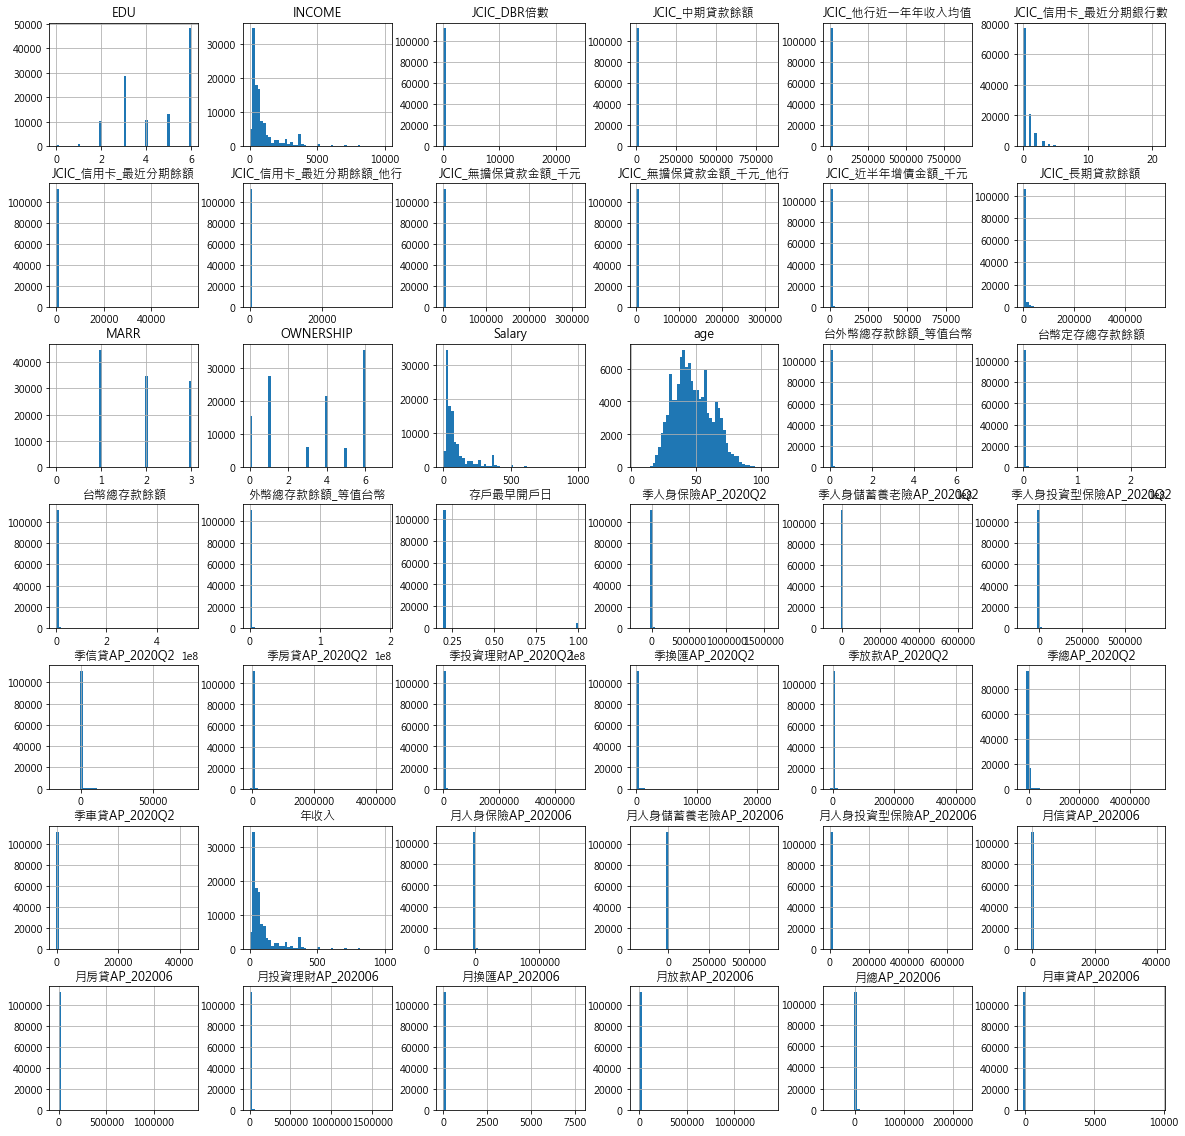

In [108]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.sans-serif':'Microsoft JhengHei', 
    'axes.unicode_minus':False})

data.hist(bins=50, figsize=(20,20))
plt.show()

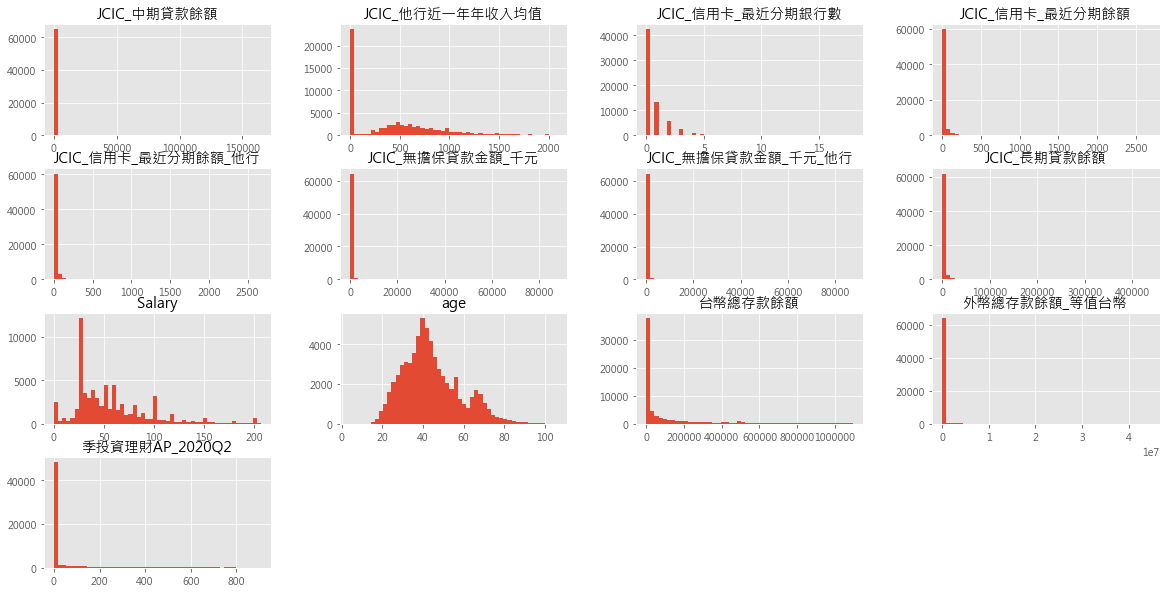

In [180]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.sans-serif':'Microsoft JhengHei', 
    'axes.unicode_minus':False})

ap_data.hist(bins=50, figsize=(20,10))
plt.show()


In [181]:
a = ap_data.shape 
print("{0}".format(a))

a = ap_label.shape 
print("{0}".format(a))

(65103, 21)
(65103,)


In [182]:
ap_feature.info()
#train_ap_data.info()
#test_ap_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 65103 entries, 0 to 112188
Columns: 687 entries, age to 曾登入行動銀行_Y
dtypes: float64(10), int64(2), object(1), uint8(674)
memory usage: 48.8+ MB


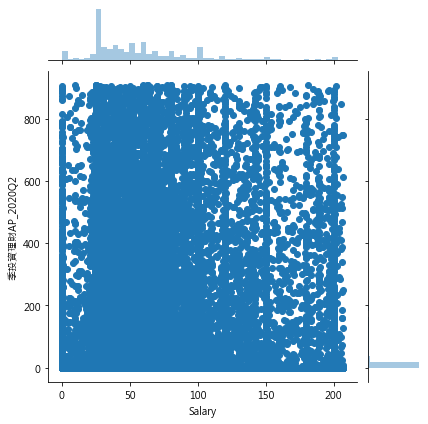

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Visualization

sns.jointplot(x='Salary',y ='季投資理財AP_2020Q2', data = ap_data)

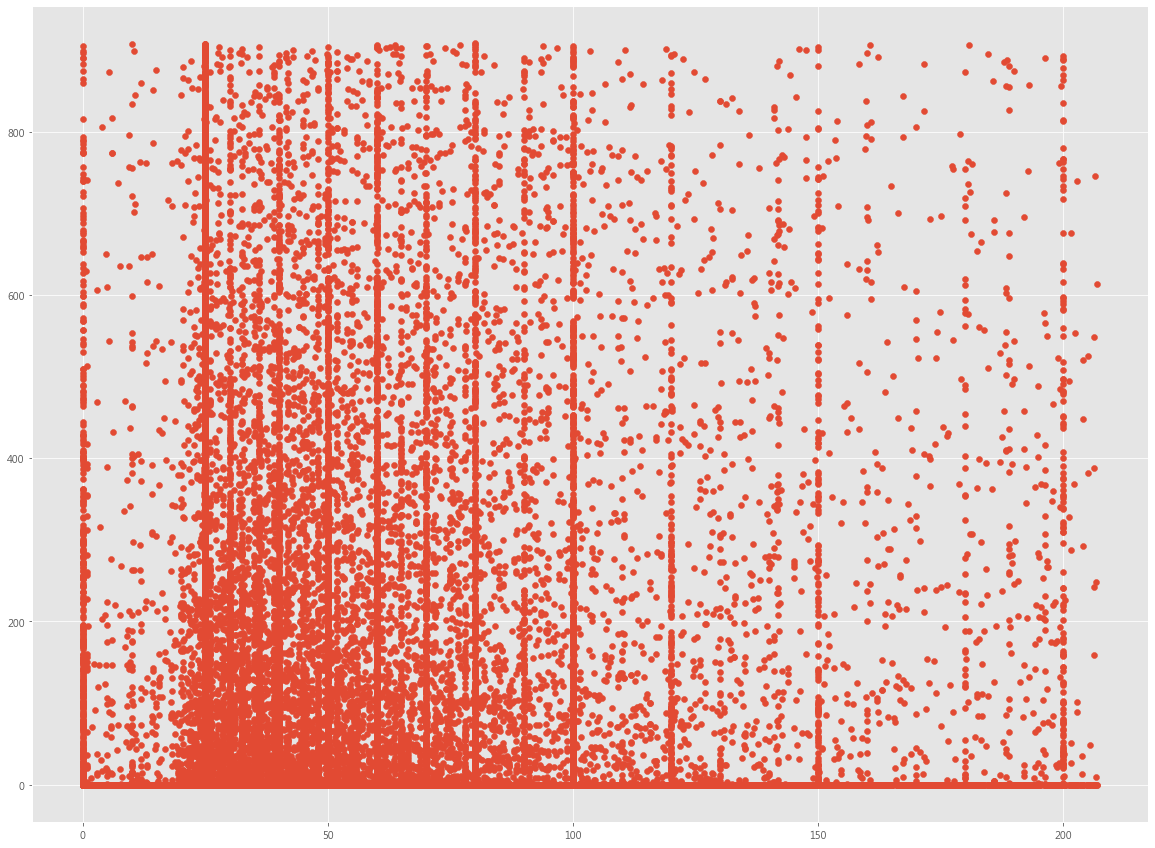

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Visualization

plt.rcParams.update({
    'font.sans-serif':'Microsoft JhengHei', 
    'axes.unicode_minus':False})

plt.rcParams.update(
    {'font.sans-serif': 'Microsoft JhengHei', 'axes.unicode_minus': False})
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(20, 15))


plt.scatter(y=ap_data["季投資理財AP_2020Q2"],x=ap_data["Salary"])

plt.show()

In [184]:
ap_data.head(5)

,性別,age,行業別_分類,現居地_區域,戶籍_區域,Salary,姻婚狀態,星座,曾登入行動銀行,台幣總存款餘額,外幣總存款餘額_等值台幣,MMA網路服務記號,JCIC_無擔保貸款金額_千元,JCIC_無擔保貸款金額_千元_他行,JCIC_信用卡_最近分期餘額,JCIC_信用卡_最近分期餘額_他行,JCIC_信用卡_最近分期銀行數,JCIC_中期貸款餘額,JCIC_長期貸款餘額,JCIC_他行近一年年收入均值,季投資理財AP_2020Q2
0,男,29.0,公營事業,新店區,新店區,60.4,其他,射手座,Y,86914.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,男,29.0,商業,屏東市,屏東市,55.0,其他,金牛座,Y,51254.0,0.0,1,7,7,7.0,7.0,1.0,0.0,9911.0,550.0,0.0
3,男,29.0,服務業,文山區,西區,35.1,其他,處女座,N,0.0,0.0,6,0,0,0.0,0.0,0.0,0.0,0.0,240.0,0.0
4,男,28.0,其他,中正區,汐止區,100.0,其他,雙魚座,Y,13769.0,0.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,男,28.0,服務業,汐止區,汐止區,63.6,其他,雙魚座,N,149793.0,0.0,1,21,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
ap_feature.head(5)

,age,Salary,台幣總存款餘額,外幣總存款餘額_等值台幣,MMA網路服務記號,JCIC_無擔保貸款金額_千元,JCIC_無擔保貸款金額_千元_他行,JCIC_信用卡_最近分期餘額,JCIC_信用卡_最近分期餘額_他行,JCIC_信用卡_最近分期銀行數,JCIC_中期貸款餘額,JCIC_長期貸款餘額,JCIC_他行近一年年收入均值,性別_ND,性別_女,性別_男,行業別_分類_公營事業,行業別_分類_其他,行業別_分類_商業,行業別_分類_專業人士,行業別_分類_教育文化業,行業別_分類_服務業,行業別_分類_營造業,行業別_分類_製造業,行業別_分類_軍政機關,行業別_分類_農漁牧礦,行業別_分類_金融業,現居地_區域_七堵區,現居地_區域_三峽區,現居地_區域_三星鄉,現居地_區域_三民區,現居地_區域_三灣鄉,現居地_區域_三義鄉,現居地_區域_三芝區,現居地_區域_三重區,現居地_區域_下營區,現居地_區域_中區,現居地_區域_中和區,現居地_區域_中埔鄉,現居地_區域_中壢區,現居地_區域_中山區,現居地_區域_中正區,現居地_區域_中西區,現居地_區域_九如鄉,現居地_區域_二崙鄉,現居地_區域_二林鎮,現居地_區域_二水鄉,現居地_區域_五結鄉,現居地_區域_五股區,現居地_區域_仁德區,現居地_區域_仁愛區,現居地_區域_仁愛鄉,現居地_區域_仁武區,現居地_區域_伸港鄉,現居地_區域_佳冬鄉,現居地_區域_佳里區,現居地_區域_來義鄉,現居地_區域_信義區,現居地_區域_信義鄉,現居地_區域_元長鄉,現居地_區域_光復鄉,現居地_區域_內埔鄉,現居地_區域_內湖區,現居地_區域_八德區,現居地_區域_八里區,現居地_區域_公館鄉,現居地_區域_六甲區,現居地_區域_六腳鄉,現居地_區域_六龜區,現居地_區域_冬山鄉,現居地_區域_前金區,現居地_區域_前鎮區,現居地_區域_北區,現居地_區域_北埔鄉,現居地_區域_北屯區,現居地_區域_北投區,現居地_區域_北斗鎮,現居地_區域_北港鎮,現居地_區域_北門區,現居地_區域_卓蘭鎮,現居地_區域_南化區,現居地_區域_南區,現居地_區域_南屯區,現居地_區域_南州鄉,現居地_區域_南庄鄉,現居地_區域_南投市,現居地_區域_南港區,現居地_區域_南澳鄉,現居地_區域_南竿鄉,現居地_區域_口湖鄉,現居地_區域_台東市,現居地_區域_台西鄉,現居地_區域_吉安鄉,現居地_區域_名間鄉,現居地_區域_后里區,現居地_區域_和平區,現居地_區域_和美鎮,現居地_區域_員山鄉,現居地_區域_員林鎮,現居地_區域_善化區,現居地_區域_嘉義市,現居地_區域_四湖鄉,現居地_區域_土城區,現居地_區域_土庫鎮,現居地_區域_坪林區,現居地_區域_埔心鄉,現居地_區域_埔里鎮,現居地_區域_埔鹽鄉,現居地_區域_埤頭鄉,現居地_區域_士林區,現居地_區域_壯圍鄉,現居地_區域_壽豐鄉,現居地_區域_外埔區,現居地_區域_大內區,現居地_區域_大同區,現居地_區域_大同鄉,現居地_區域_大園區,現居地_區域_大城鄉,現居地_區域_大埤鄉,現居地_區域_大安區,現居地_區域_大寮區,現居地_區域_大村鄉,現居地_區域_大林鎮,現居地_區域_大樹區,現居地_區域_大湖鄉,現居地_區域_大溪區,現居地_區域_大甲區,現居地_區域_大社區,現居地_區域_大肚區,現居地_區域_大里區,現居地_區域_大雅區,現居地_區域_太保市,現居地_區域_太平區,現居地_區域_安南區,現居地_區域_安定區,現居地_區域_安平區,現居地_區域_安樂區,現居地_區域_官田區,現居地_區域_宜蘭巿,現居地_區域_富里鄉,現居地_區域_寶山鄉,現居地_區域_小港區,現居地_區域_尖石鄉,現居地_區域_屏東市,現居地_區域_山上區,現居地_區域_岡山區,現居地_區域_崙背鄉,現居地_區域_左營區,現居地_區域_布袋鎮,現居地_區域_平溪區,現居地_區域_平鎮區,現居地_區域_彌陀區,現居地_區域_彰化市,現居地_區域_後壁區,現居地_區域_後龍鎮,現居地_區域_復興區,現居地_區域_恆春鎮,現居地_區域_成功鎮,現居地_區域_文山區,現居地_區域_斗六市,現居地_區域_斗南鎮,現居地_區域_新化區,現居地_區域_新園鄉,現居地_區域_新城鄉,現居地_區域_新埔鎮,現居地_區域_新埤鄉,現居地_區域_新屋區,現居地_區域_新市區,現居地_區域_新店區,現居地_區域_新港鄉,現居地_區域_新營區,現居地_區域_新社區,現居地_區域_新竹市,現居地_區域_新興區,現居地_區域_新莊區,現居地_區域_新豐鄉,現居地_區域_旗山區,現居地_區域_旗津區,現居地_區域_暖暖區,現居地_區域_朴子市,現居地_區域_杉林區,現居地_區域_東勢區,現居地_區域_東勢鄉,現居地_區域_東區,現居地_區域_東山區,現居地_區域_東引鄉,現居地_區域_東港鎮,現居地_區域_東石鄉,現居地_區域_松山區,現居地_區域_板橋區,現居地_區域_枋寮鄉,現居地_區域_林內鄉,現居地_區域_林口區,現居地_區域_林園區,現居地_區域_林邊鄉,現居地_區域_柳營區,現居地_區域_桃園區,現居地_區域_梅山鄉,現居地_區域_梓官區,現居地_區域_梧棲區,現居地_區域_楊梅區,現居地_區域_楠梓區,現居地_區域_樹林區,現居地_區域_橋頭區,現居地_區域_橫山鄉,現居地_區域_歸仁區,現居地_區域_民雄鄉,現居地_區域_水上鄉,現居地_區域_水里鄉,現居地_區域_永和區,現居地_區域_永安區,現居地_區域_永康區,現居地_區域_永靖鄉,現居地_區域_汐止區,現居地_區域_池上鄉,現居地_區域_沙鹿區,現居地_區域_泰山區,現居地_區域_淡水區,現居地_區域_深坑區,現居地_區域_清水區,現居地_區域_湖內區,現居地_區域_湖口鄉,現居地_區域_湖西鄉,現居地_區域_溪口鄉,現居地_區域_溪州鄉,現居地_區域_溪湖鎮,現居地_區域_潭子區,現居地_區域_潮州鎮,現居地_區域_烈嶼鄉,現居地_區域_烏來區,現居地_區域_烏日區,現居地_區域_燕巢區,現居地_區域_獅潭鄉,現居地_區域_玉井區,現居地_區域_玉里鎮,現居地_區域_琉球鄉,現居地_區域_瑞穗鄉,現居地_區域_瑞芳區,現居地_區域_田中鎮,現居地_區域_田寮區,現居地_區域_田尾鄉,現居地_區域_甲仙區,現居地_區域_番路鄉,現居地_區域_白沙鄉,現居地_區域_白河區,現居地_區域_石岡區,現居地_區域_石碇區,現居地_區域_石門區,現居地_區域_礁溪鄉,現居地_區域_社頭鄉,現居地_區域_神岡區,現居地_區域_福興鄉,現居地_區域_秀林鄉,現居地_區域_秀水鄉,現居地_區域_竹北市,現居地_區域_竹南鎮,現居地_區域_竹塘鄉,現居地_區域_竹山鎮,現居地_區域_竹崎鄉,現居地_區域_竹東鎮,現居地_區域_竹田鄉,現居地_區域_綠島鄉,現居地_區域_線西鄉,現居地_區域_羅東鎮,現居地_區域_美濃區,現居地_區域_芎林鄉,現居地_區域_芬園鄉,現居地_區域_花壇鄉,現居地_區域_花蓮市,現居地_區域_芳苑鄉,現居地_區域_苑裡鎮,現居地_區域_苓雅區,現居地_區域_苗栗市,現居地_區域_茄萣區,現居地_區域_草屯鎮,現居地_區域_莿桐鄉,現居地_區域_萬丹鄉,現居地_區域_萬巒鄉,現居地_區域_萬榮鄉,現居地_區域_萬華區,現居地_區域_萬里區,現居地_區域_蘆洲區,現居地_區域_蘆竹區,現居地_區域_蘇澳鎮,現居地_區域_虎尾鎮,現居地_區域_褒忠鄉,現居地_區域_西區,現居地_區域_西屯區,現居地_區域_西港區,現居地_區域_西湖鄉,現居地_區域_西螺鎮,現居地_區域_觀音區,現居地_區域_豐原區,現居地_區域_豐濱鄉,現居地_區域_貢寮區,現居地_區域_路竹區,現居地_區域_車城鄉,現居地_區域_通霄鎮,現居地_區域_造橋鄉,現居地_區域_里港鄉,現居地_區域_金城鎮,現居地_區域_金寧鄉,現居地_區域_金山區,現居地_區域_金沙鎮,現居地_區域_金湖鎮,現居地_區域_銅鑼鄉,現居地_區域_長治鄉,現居地_區域_關廟區,現居地_區域_關西鎮,現居地_區域_阿蓮區,現居地_區域_阿里山,現居地_區域_雙溪區,現居地_區域_霧台鄉,現居地_區域_霧峰區,現居地_區域_頭份鎮,現居地_區域_頭城鎮,現居地_區域_頭屋鄉,現居地_區域_馬公市,現居地_區域_高樹鄉,現居地_區域_魚池鄉,現居地_區域_鳥松區,現居地_區域_鳳山區,現居地_區域_鶯歌區,現居地_區域_鹽埔鄉,現居地_區域_鹽埕區,現居地_區域_鹽水區,現居地_區域_鹿港鎮,現居地_區域_鹿谷鄉,現居地_區域_鹿野鄉,現居地_區域_麟洛鄉,現居地_區域_麥寮鄉,現居地_區域_麻豆區,現居地_區域_鼓山區,現居地_區域_龍井區,現居地_區域_龍崎區,現居地_區域_龍潭區,現居地_區域_龜山區,戶籍_區域_七堵區,戶籍_區域_七美鄉,戶籍_區域_七股區,戶籍_區域_三地門,戶籍_區域_三峽區,戶籍_區域_三星鄉,戶籍_區域_三民區,戶籍_區域_三灣鄉,戶籍_區域_三義鄉,戶籍_區域_三芝區,戶籍_區域_三重區,戶籍_區域_下營區,戶籍_區域_中區,戶籍_區域_中和區,戶籍_區域_中埔鄉,戶籍_區域_中壢區,戶籍_區域_中寮鄉,戶籍_區域_中山區,戶籍_區域_中正區,戶籍_區域_中西區,戶籍_區域_九如鄉,戶籍_區域_二崙鄉,戶籍_區域_二林鎮,戶籍_區域_二水鄉,戶籍_區域_五結鄉,戶籍_區域_五股區,戶籍_區域_仁德區,戶籍_區域_仁愛區,戶籍_區域

In [186]:
ap_label.head(5)

0    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: 季投資理財AP_2020Q2, dtype: float64

In [187]:
from sklearn.model_selection import train_test_split

train_ap_data, test_ap_data, train_ap_label, test_ap_label = train_test_split(ap_feature, ap_label)

In [188]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
reg = linear_model.LinearRegression()

In [189]:
reg.fit(train_ap_data,train_ap_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [193]:
reg.score(train_ap_data,train_ap_label)

0.2910743499826798

In [192]:
reg.score(test_ap_data,test_ap_label)

0.25326300491706244

In [191]:
a = reg.intercept_
print("intercept: {0}".format(a))
      
a = reg.coef_
print("coef: {0}".format(a))    

a = train_ap_data.columns
print("x_columns: {0}".format(a))    

intercept: 108.7695091381627
coef: [ 9.25537304e-01  1.04648556e-01  7.71545900e-05  2.65992351e-05
  2.66337404e+00 -7.71158588e-03  4.72420209e-03 -3.96721439e-02
  5.56077899e-02 -4.80618610e+00  1.78929309e-05  5.11551520e-04
  8.10691448e-04 -1.88293825e-13  8.46086090e+01 -8.46086090e+01
  3.83935134e-01  6.85383185e+00 -8.77990861e-01 -2.49773764e+01
  9.59345100e+00 -6.93262371e-01  7.21334455e-01  9.69797001e+00
  7.90010158e+00  4.52735835e+00 -1.31293528e+01 -9.48740671e+00
 -1.22604822e+01 -2.26013264e+01  6.33141846e+00  2.65753473e+02
 -4.86776914e+02 -4.08612940e+00 -1.27477432e+01 -1.38952410e+02
  3.85710873e+01 -1.23500464e+01  2.07989690e+01 -4.44997695e+00
 -2.19677637e+01  4.09812147e+00 -4.50664742e+01  2.94772843e+02
 -5.46080012e+01 -1.49230850e+02 -1.01894138e+02 -1.58568523e+01
 -2.45927406e+01 -3.74158767e+01  2.98785304e+01 -2.28584967e+02
  8.06662638e+00  1.37272346e+02  8.43383829e+01 -1.25820244e+02
 -2.18270011e+01 -1.50195180e+01 -4.41735548e+01  1.225

In [ ]:
train_ap_data, test_ap_data, train_ap_label, test_ap_label = train_test_split(ap_feature, ap_label)